In [1]:
import pandas as pd
from obspy import read
import obspy
from obspy.signal import PPSD
from numpy import where,mean
from glob import glob
from matplotlib import pyplot as plt

import numpy as np

from obspy import read
from pathlib import Path


from noise_utils import psd_stack2hist_stack, _plot_histogram, get_percentile, _plot_histogram_RX


pq_file='/home/ec2-user/pgv_ml/synth_gnss_vel/data/ambient_5sps_6yr.pq'
df3=pd.read_parquet(pq_file)

In [ ]:
df3

In [2]:
def df_2_rx(df):
    try:
        url='https://data.unavco.org/archive/gnss/highrate/5-Hz/rinex/%s/%s/%s/%s%s0.%sS' %(df.year,df.doy,df.station,df.station,df.doy,df.year[-2:])
        #print(url)
        data = urllib.request.urlopen(url)
        for line in data:
        #print(line)
            if line.startswith(b'Receiver type'):
                rx=line.decode().split()[3]
                md=line.decode().split()[4]

                break
    except:
        rx='UNKNOWN'
        md='UNKNOWN'
    return [rx,md]

In [ ]:
new_cols=[]
for row in df3.iterrows():
    new_cols.append(df_2_rx(row[1]))

In [ ]:
df4=pd.concat((df3,pd.DataFrame(new_cols, columns=['rx','md'])), axis=1)
new_pq_file='/home/ec2-user/pgv_ml/synth_gnss_vel/data/ambient_5sps_6yr_RX.pq'
df4.to_parquet(new_pq_file)

In [ ]:
pq_file='/home/ec2-user/pgv_ml/synth_gnss_vel/data/ambient_5sps_6yr_RX.pq'
df2=pd.read_parquet(pq_file)

In [ ]:
df2[df2.year.astype('int')>2019]

In [ ]:
A = 20*log10(V2/V1)

In [ ]:
20*np.log10(.01**2)

246
201


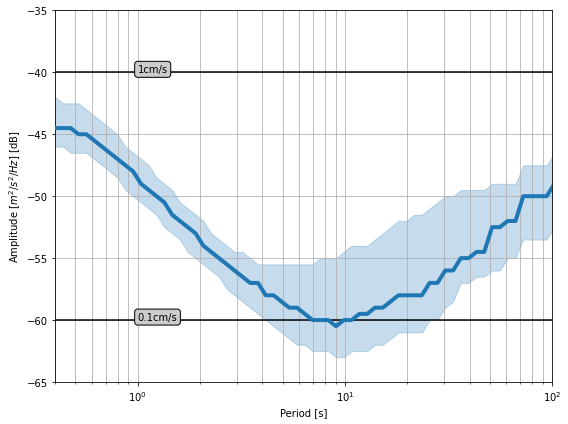

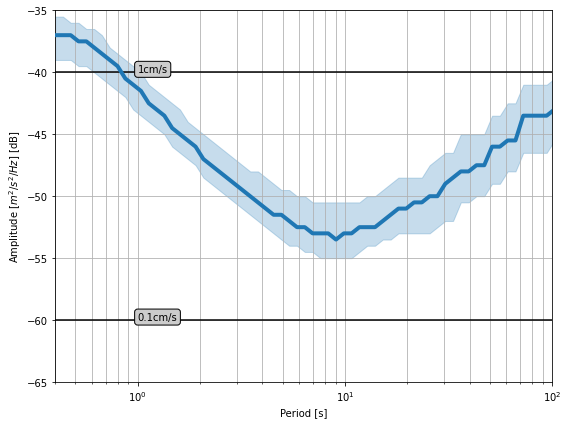

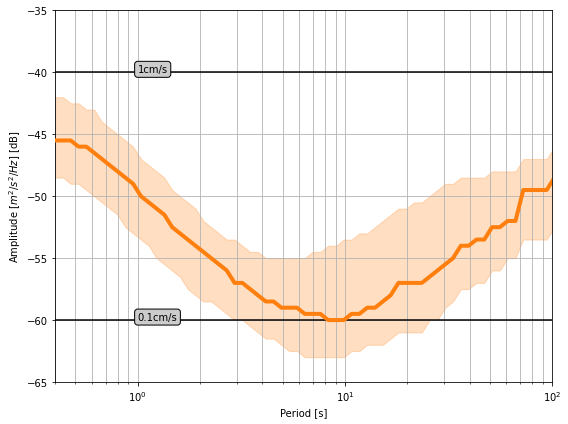

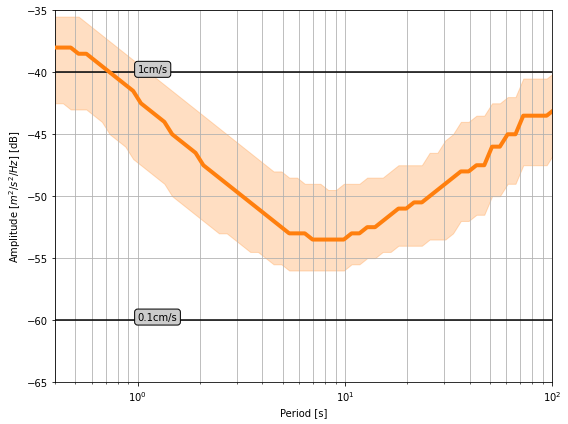

In [3]:

import pandas as pd
from obspy import read
import obspy
from obspy.signal import PPSD
from numpy import where,mean
from glob import glob
from matplotlib import pyplot as plt

import numpy as np

from obspy import read
from pathlib import Path


from noise_utils import psd_stack2hist_stack, _plot_histogram, get_percentile


pq_file='/home/ec2-user/pgv_ml/synth_gnss_vel/data/ambient_5sps_6yr_RX.pq'
df2=pd.read_parquet(pq_file)

df2=df2[df2.year.astype('int')>2019]

sac_dir='/home/ec2-user/pgv_ml/synth_gnss_vel/data/ambient_sac/'

H_val=[]
V_val=[]
 
db_bins=(-65, -35, 0.5)
ppsd_length=3600/3
period_limits=[2/5,600]

for rx_type,color in zip(['TRIMBLE','SEPT'],['tab:blue','tab:orange']):
    df3=df2[df2.rx==rx_type]
    print(len(df3))
    for row in df3.iterrows():
    #for k in np.arange(1):
        try:
            site=row[1].station.upper()
            
            doy=row[1].doy
            year=row[1].year

            e = read(sac_dir+site.upper()  + '_' + doy + '_' + year +  '.vel.e', debug_headers=True) 
            n = read(sac_dir+site.upper()  + '_' + doy + '_' + year +  '.vel.n', debug_headers=True)
            z = read(sac_dir+site.upper()  + '_' + doy + '_' + year +  '.vel.u', debug_headers=True)

            paz = {'gain': 1,'poles': [1],'sensitivity': 1,'zeros': [0, 1j]}

            Eppsd = PPSD(e[0].stats, paz, db_bins=db_bins,ppsd_length=ppsd_length, special_handling="ringlaser")
            Nppsd = PPSD(n[0].stats, paz, db_bins=db_bins,ppsd_length=ppsd_length, special_handling="ringlaser")
            Zppsd = PPSD(z[0].stats, paz, db_bins=db_bins,ppsd_length=ppsd_length, special_handling="ringlaser")

            #Add traces to ppsd object
            Eppsd.add(e) 
            Nppsd.add(n) 
            Zppsd.add(z) 
            H_val+=Eppsd.psd_values
            H_val+=Nppsd.psd_values
            V_val+=Zppsd.psd_values

        except:
            pass

    H_stacked=np.vstack(H_val)
    V_stacked=np.vstack(V_val)

    '''
    np.save('models/e_stacked_ambient.npy', e_stacked) 
    np.save('models/n_stacked_ambient.npy', n_stacked) 
    np.save('models/z_stacked_ambient.npy', z_stacked) 

    Eppsd.save_npz("models/Eppsd.npz") 
    Nppsd.save_npz("models/Nppsd.npz")
    Zppsd.save_npz("models/Zppsd.npz")

    '''


    for psd_stack_array,name in zip([H_stacked,V_stacked],["H","V"]):
        hist_stack, hist_stack_cumul=psd_stack2hist_stack(psd_stack_array, Eppsd)
        filename='/home/ec2-user/pgv_ml/synth_gnss_vel/noise/plots/%s_ambientnoise_%s.png' %(rx_type,name)
        fig, _db_bin_edges, period_bin_centers, percentiles=_plot_histogram_RX(Eppsd, hist_stack,hist_stack_cumul, db_bins, draw=False, filename=filename, pltcolor=color)
        '''
        # save to array
        per_li=[]
        for i,percentile in enumerate(np.arange(5,100,5)):
            periods, percentile_values=get_percentile(hist_stack_cumul, percentile, _db_bin_edges, period_bin_centers)
            if i == 0:
                per_li.append(periods)
            per_li.append(percentile_values)
        per_array=pd.DataFrame(per_li)
        new_header = per_array.iloc[0] #grab the first row for the header
        per_array = per_array[1:] #take the data less the header row
        per_array.columns = new_header #set the header row as the df header
        per_array['percentile']=np.arange(5,100,5)
        per_array=per_array.set_index('percentile')
        #per_array.to_csv("/home/ec2-user/pgv_ml/synth_gnss_vel/data/%s_psd_percentiles.csv" %name)
        '''


In [9]:
len(Eppsd.period_bin_centers)

73

In [ ]:
df['receiver','md']

In [ ]:
url='https://data.unavco.org/archive/gnss/rinex/qc/2012/001/1ulm0010.12S'
with open(url,"r") as fi:
    id = []
    for ln in fi:
        if ln.startswith("Receiver type:"):
            id.append(ln[2:])
print(id)

In [ ]:
import urllib2  # the lib that handles the url stuff

data = urllib2.urlopen(url) # it's a file like object and works just like a file
for line in data: # files are iterable
    print(line)

In [ ]:
import urllib.request


data = urllib.request.urlopen(url)
for line in data:
    #print(line)
    if line.startswith(b'Receiver type'):
        print(line.decode().split()[3])
        print(line.decode().split()[4])
             
        break